# CNN on Cifar10

What would be a deep learning example / tutorial series without an example of image classification eh? In this notebook, we're going to define a small sized CNN and train it on CIFAR10. Actually, this notebook is mostly taken from the pytorch example on the same topic, which you can find [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

So let me give you a brief overview of what we're going to do. 

1. Load the `cifar10` dataset from `torchvision`
2. Define a simple CNN and see how Convolution module works in Flax

## Dataset and Dataloaders

In [1]:
import torch
import jax_dataloader as jdl
import torchvision
import torchvision.transforms as transforms

/home/shawon/Projects/jax_examples/venv/lib64/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Now one thing to note here. Torchvision datasets will return images as Torch tensors which are not compatible with Jax. Workaround? Write a transform to convert them to numpy.

In [2]:
class ToNumpy:
    def __call__(self, x: torch.Tensor):
        return x.numpy()

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ToNumpy()])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:08<00:00, 20540710.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
batch_size = 128

trainloader = jdl.DataLoader(trainset, backend="pytorch", batch_size=batch_size,
                                          shuffle=True)
testloader = jdl.DataLoader(testset, backend="pytorch", batch_size=batch_size,
                                         shuffle=False)

In [6]:
# classes in cifar10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Model

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
import flax.linen as nn

In [8]:
from einops import rearrange

class ConvNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        # convs
        out = nn.Conv(features=6, kernel_size=(5, 5))(x)
        out = nn.max_pool(out, window_shape=(2, 2))
        out = nn.Conv(features=16, kernel_size=(5, 5))(out)
        out = nn.max_pool(out, window_shape=(2, 2))


        # flatten into a vector 
        # skip the batch dim
        if len(x.shape) > 3:
            out = rearrange(x, "batch c h w -> batch (c h w)")
        else:
            out = out.flatten()

        # dense
        out = nn.Dense(features=120)(out)
        out = nn.Dense(features=84)(out)
        out = nn.Dense(features=10)(out)

        return out

Okay, let's have a look at the `Conv` module in Flax. The `features` parameter is, in my opinion, wrongly named here, and can create confusion but I suppose they had to keep the API consisten in between the Linen modules. 

Anyways, the `features` parameter designates the number of output channels in the output of the Convolution layer. Now is it a 2D conv or 1D or 3D? Flax doesn't have separate Conv classes for multi-dim conv, unlike pytorch. So you can just pass in multi dim arrays as long as you define your network properly. If you're wondering what the number of channels in a conv output means, let's say that you want to convolve using `n` filters of `(a, b)` size. The output size of your conv operation will then be `n x a x b`. If you wish to read more on the math behind it, I strongly recommend reading the related chapter from the [Deep Learning](https://www.deeplearningbook.org/contents/convnets.html) book.

Next is the `kernel_size` parameter, which is quite self explanatory. I've used a `5 x 5` size filter. You can fiddle around with different filter sizes and see which one fits your needs. 

As for other parameters, such as stride, dilation, padding, they're set to default as mentioned in the [docs](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.Conv.html). 

If you wish to read more on padding strategies, read [here](https://www.knowledgehut.com/blog/data-science/padding-in-cnn). The default padding strategy in Flax is "VALID". 

Apart from the two conv layers, there are two `max_pool` layers which do max pooling. It is a function, unlike the Conv module, so you have to just pass in the array and the size of the pooling window. Next comes a flatten operation which skips the batch dimension, followed by 3 dense layers to project the model outputs to the number of classes. 

Okay, now to do the usual thing, init model and train. 

In [10]:
model = ConvNet()
params = model.init(jax.random.key(0), jnp.empty((3, 32, 32)))

In [11]:
# run a sample forward pass
logits = model.apply(params, jnp.empty((3, 32, 32)))
logits.shape

(10,)

#### Loss function

In [12]:
import optax

@jax.jit
def calculate_loss(params, x, y):
    logits = model.apply(params, x)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y)
    return loss

@jax.jit
def batched_loss(params, xs, ys):
    batch_loss = jax.vmap(calculate_loss, in_axes=(None, 0, 0))(params, xs, ys)
    return batch_loss.mean(axis=-1)

In [14]:
calculate_loss(params, jnp.empty((3, 32, 32)), 1)

Array(2.3025851, dtype=float32)

In [15]:
# check the batched loss thing
for batch in trainloader:
    loss = batched_loss(params, *batch)
    print(loss)
    break

2.3177273


In [16]:
from tqdm.auto import trange, tqdm
from flax.training import train_state
from functools import partial


optimiser = optax.adam(learning_rate=0.001)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser
)
criterion = jax.value_and_grad(batched_loss)

In [17]:
@jax.jit
def train_step(state, batch):
    loss_value, grads = criterion(state.params, *batch)
    updated_state = state.apply_gradients(grads=grads)
    return loss_value, updated_state

#### Evaluation

It's a classification task, so let's just check on the f1 score for now. 

In [18]:
from sklearn.metrics import f1_score

@jax.jit
def test_step(state, xs):
    def infer(params, x):
        logits = model.apply(params, x)
        return jax.nn.softmax(logits, axis=-1) 

    preds = jax.vmap(jax.jit(infer), in_axes=(None, 0))(state.params, xs)
    return preds



def evaluate(state, test_loader):
    scores = list()
    for batch in tqdm(test_loader):
        xs, ys = batch
        preds = test_step(state, xs)
        preds = jnp.argmax(preds, axis=-1)
        f1 = f1_score(preds, ys, average="micro")
        scores.append(f1)

    return np.array(scores).mean(axis=-1)

In [19]:
# test the evaluation function
evaluate(state, testloader)

  0%|          | 0/79 [00:00<?, ?it/s]

0.10808939873417721

Since we're using scikit-learn for evaluation anyway, it will also be nice if we can get a detailed classification report.

In [20]:
from sklearn.metrics import classification_report


def custom_classification_report(params, test_loader):
    preds = list()
    actual = list()
    for batch in tqdm(test_loader):
        xs, ys = batch
        pred = test_step(state, xs)
        pred = jnp.argmax(pred, axis=-1).tolist()
        preds.extend(pred)
        actual.extend(ys.tolist())

    clf = classification_report(preds, actual, target_names=classes)
    print(clf)

In [21]:
custom_classification_report(state.params, testloader)

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       plane       0.00      0.17      0.00         6
         car       0.45      0.12      0.19      3799
        bird       0.00      0.05      0.00        21
         cat       0.02      0.11      0.04       223
        deer       0.18      0.08      0.11      2350
         dog       0.01      0.16      0.02        57
        frog       0.01      0.11      0.01        75
       horse       0.17      0.09      0.12      1923
        ship       0.25      0.16      0.20      1541
       truck       0.00      0.00      0.00         5

    accuracy                           0.11     10000
   macro avg       0.11      0.10      0.07     10000
weighted avg       0.28      0.11      0.15     10000



Perfect. Now we can move to the train loop and add the evaluation there as well so that we can check how the f1 score changes during training.

In [22]:
from tqdm.auto import trange

def train(state, epochs, train_loader, test_loader):
    steps = 0
    losses = []
    f1s = []

    # =============
    for e in trange(5):
        for batch in tqdm(train_loader):
            loss, state = train_step(state, batch)
            steps += 1

            # log every 200 steps
            if steps % 200 == 0:
                losses.append(loss)
                
                # run evaluation
                print("Evaluating ... ")
                score = evaluate(state, test_loader)
                
                f1s.append(score)
    
                print(f"Epoch : {e + 1} :: Step : {steps} :: Loss : {loss}  :: F1 : {score}")

    # ============
    return state, losses, f1s

In [24]:
state, losses, f1s = train(state, 5, trainloader, testloader)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 1 :: Step : 200 :: Loss : 1.420501708984375  :: F1 : 0.4317642405063291


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 2 :: Step : 400 :: Loss : 1.4548004865646362  :: F1 : 0.4642009493670886
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 2 :: Step : 600 :: Loss : 1.6473182439804077  :: F1 : 0.48951740506329117


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 3 :: Step : 800 :: Loss : 1.521551251411438  :: F1 : 0.48358386075949367
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 3 :: Step : 1000 :: Loss : 1.4645955562591553  :: F1 : 0.49624208860759494


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 4 :: Step : 1200 :: Loss : 1.4096702337265015  :: F1 : 0.5100870253164557
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 4 :: Step : 1400 :: Loss : 1.2829735279083252  :: F1 : 0.5018789556962026


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 5 :: Step : 1600 :: Loss : 1.3250913619995117  :: F1 : 0.5089992088607594
Evaluating ... 


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 5 :: Step : 1800 :: Loss : 1.2746849060058594  :: F1 : 0.5096914556962026


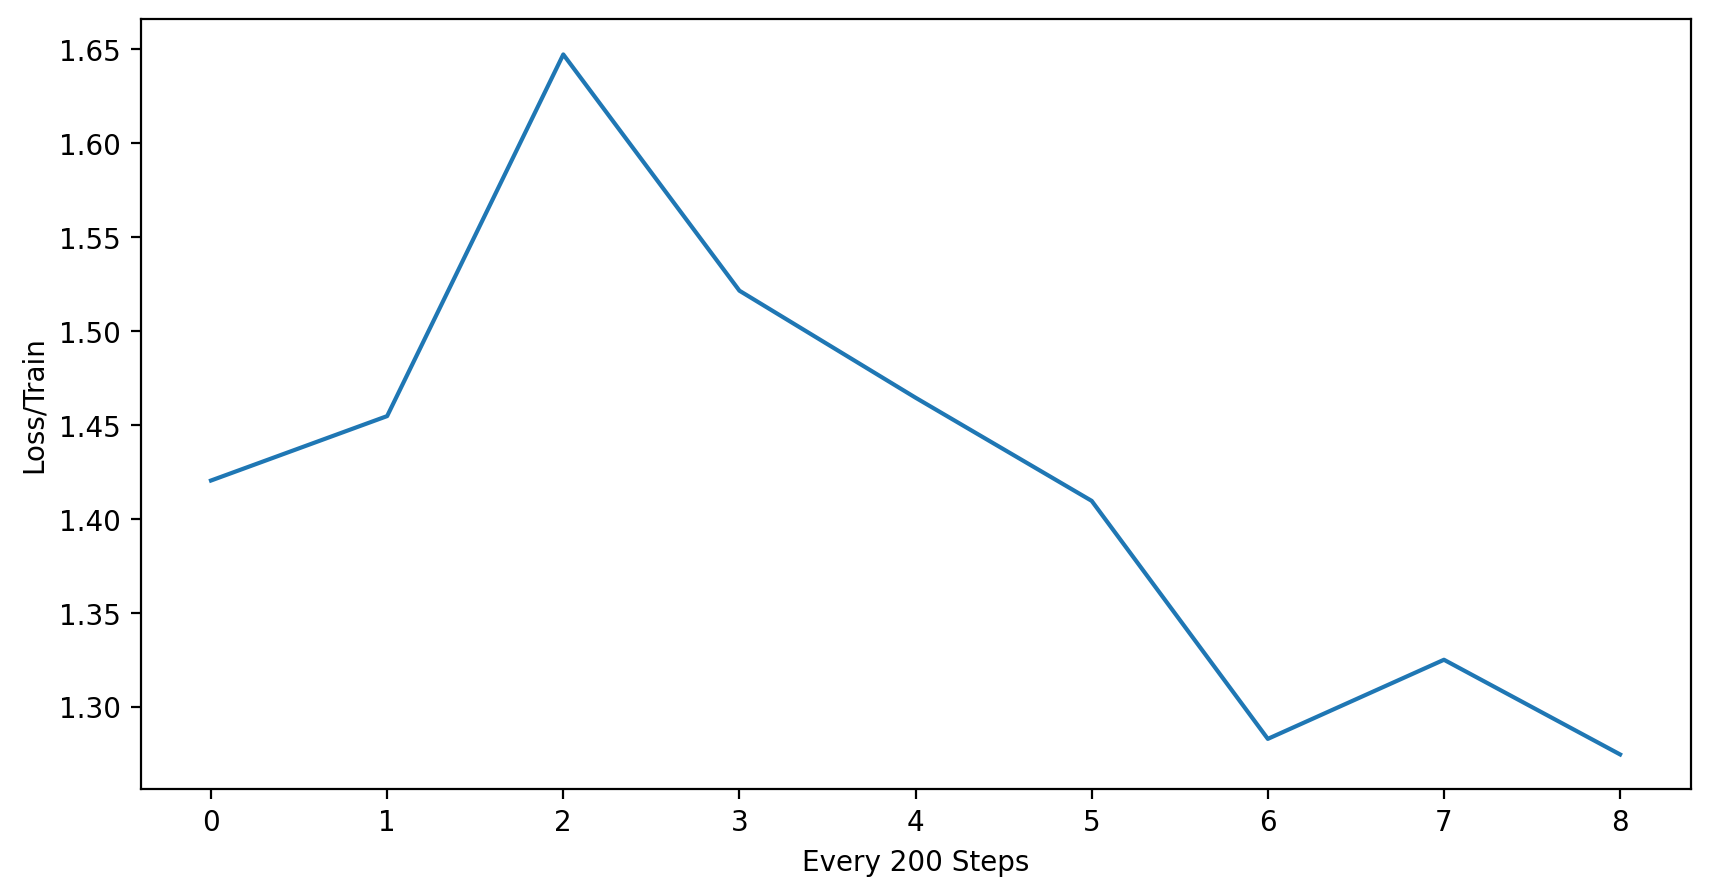

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(10, 5))
fig.add_subplot()
plt.xlabel("Every 200 Steps")
plt.ylabel("Loss/Train")
plt.plot(np.arange(len(losses)), losses)

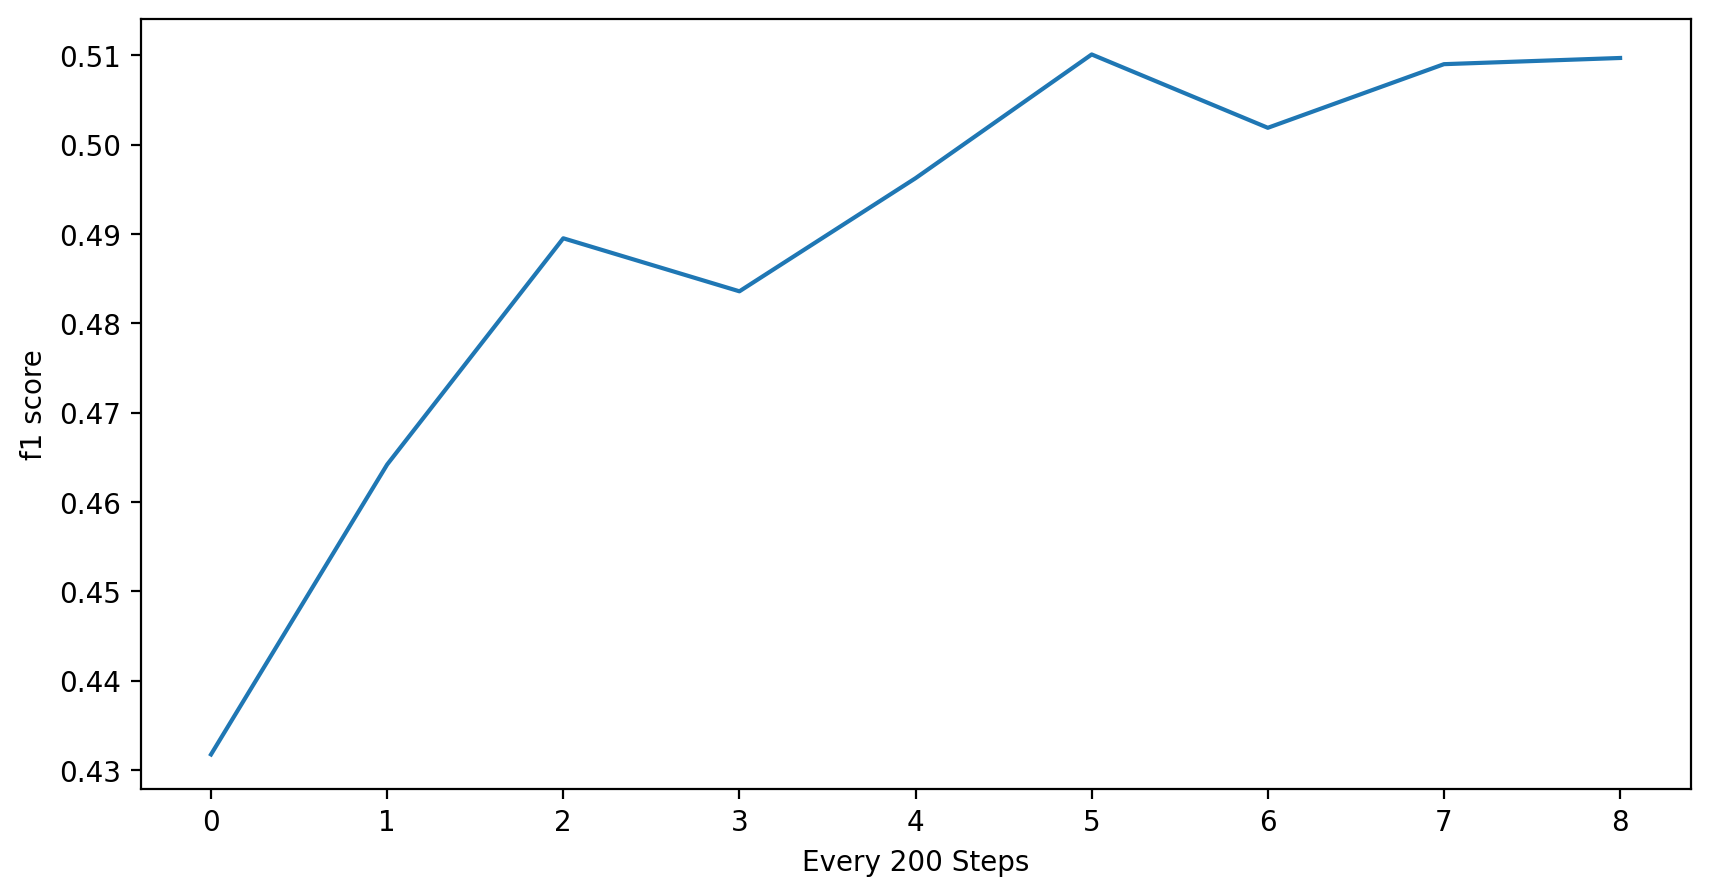

In [28]:
fig2 = plt.figure(figsize=(10, 5))
fig2.add_subplot()
plt.xlabel("Every 200 Steps")
plt.ylabel("f1 score")
plt.plot(np.arange(len(f1s)), f1s)



#### Class wise classification results

In [29]:
custom_classification_report(state.params, testloader)

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       plane       0.50      0.59      0.54       844
         car       0.61      0.63      0.62       970
        bird       0.44      0.38      0.41      1157
         cat       0.33      0.38      0.35       862
        deer       0.46      0.43      0.44      1076
         dog       0.37      0.51      0.43       732
        frog       0.61      0.54      0.57      1134
       horse       0.59      0.62      0.60       955
        ship       0.74      0.57      0.64      1308
       truck       0.55      0.57      0.56       962

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.53      0.52      0.52     10000

